In [1]:
from transformers import pipeline, set_seed
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from accelerate.utils import release_memory
import torch
from datasets import Dataset
from huggingface_hub import login
from IPython.display import display, Markdown

from langchain.text_splitter import CharacterTextSplitter, HTMLHeaderTextSplitter
from langchain.llms.base import LLM
from langchain.prompts import PromptTemplate

from langchain.chains.summarize import load_summarize_chain
from typing import Any

import pandas as pd
import kagglehub
from kaggle_secrets import UserSecretsClient
import gc
import warnings
import random
import numpy as np

warnings.filterwarnings('ignore')


# Ensuring consistent results by fixing the seed for all random number generators
set_seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

writeups = pd.read_csv('/kaggle/input/kaggle-winning-solutions-methods/kaggle_winning_solutions_methods.csv')
writeups = writeups.drop_duplicates(subset=['link', 'writeup']).reset_index(drop=True)

# hf_access_token = UserSecretsClient().get_secret("hf_mytoken")
# login(token = hf_access_token)

model = "/kaggle/input/gemma/transformers/2b-it/3"

pipe = pipeline(
    "text-generation",
    model=model,
    model_kwargs={"torch_dtype": torch.float16},
    device='cuda',
    max_new_tokens=512
)

2025-06-10 15:41:57.598810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749570117.832654      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749570117.900160      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [2]:
# first writeup
writeup = writeups.iloc[0,9]
print(f'number of characters:{len(writeup)}')

number of characters:9864


In [3]:
# simulation of chat
messages = [
    {
        "role": "user",
        "content": "Summarize the following text in a technical way. Focus on facts, numbers and strategies used. Divide the summary in chapters, be impersonal and use bullet points:\n\n{}".format(writeup)
    }
]

In [4]:
# most of LLMs use is in CHAT format -> the model recieves a messsage and tries to answer
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# generate an output based on prompt using defined pipe:
outputs = pipe(
    prompt,
    do_sample=True,
    temperature=0.1,
    top_k=20,
    top_p=0.3,
    add_special_tokens=True   
)

# cutting the beggining (firtst len(prompt) characters -> we want to see just summary)
display(Markdown(outputs[0]['generated_text'][len(prompt):].replace('#', '')))

**Chapter 1: Introduction**

* Overview of the project: using an EfficientNet-B0 model for lip and pose classification.
* Data preparation:
    * 18 lip points, 20 pose points, and all hand points were extracted.
    * Various augmentations and transformer pre-processing were applied.
    * The input size was 160x80x3.

**Chapter 2: Data Preprocessing**

* CNN pre-processing:
    * Global affine, shift-scale-rotate, and flip pose were applied.
    * Mixup augmentation was used for CNNs.
* Transformer pre-processing:
    * Only 61 points were kept, including 40 lip points and 21 hand points.
    * Randomly selected distances and angles were included.

**Chapter 3: Training**

* CNN training:
    * One-fold cross-validation with a random split and 0.1 warm-up.
    * Weighted cross-entropy loss with class weights.
    * EfficientNet-B0 with 5 blocks and 256 hidden units.
* Transformer training:
    * One-fold cross-validation with a random split and 0.1 warm-up.
    * Ranger optimizer with 60% flat and 40% cosine annealing learning rate schedule.
    * 4-layer, 256 hidden-size, 512 intermediate-size transformer.

**Chapter 4: Hyperparameter Tuning**

* Optuna was used to tune most parameters.
* The parameters list for CNN and transformer training are provided.

**Chapter 5: Submissions and Ensemble**

* EfficientNet-B0 achieved a leaderboard score of approximately 0.8.
* Ensemble of EfficientNet-B0, BERT, and DeBERTa was created.
* A key feature was using the ensemble without softmax, which provided a boost of around 0.01.

**Chapter 6: Conclusion**

* The project achieved a high accuracy on the lip and pose classification task.
* The EfficientNet-B0 model with ensemble achieved the best performance.
* The conversion of DepthwiseConv2D operation was a challenge, but a faster version was developed.

## Prompt engineering
- depending on the audience, the prompt can vary -> we want it to be more aligned with user's needs
- example:

In [5]:
messages_eli5 = [
    {
        "role":"user",
        "content": "Summarize the following text as if I am 5 year old: {}".format(writeup)
    }
]

prompt_eli5 = pipe.tokenizer.apply_chat_template(messages_eli5, tokenize=False, add_generation_prompt=True)
output_eli5 = pipe(
    prompt_eli5,
    add_special_tokens=True,
    top_p=0.3,
    top_k=20,
    temperature=0.1,
    do_sample=True
)

display(Markdown(output_eli5[0]["generated_text"][len(prompt_eli5):].replace('#', '')))

Sure, here's a summary of the text:

**Data Preprocessing:**

* Extract 80 points from the image, including lip and body points.
* Apply various augmentations and normalizations.
* Use a specific interpolation method to handle the time axis.

**Training:**

* Use EfficientNet-B0 for CNN training and transformers for the transformer.
* Train on one fold with a random split and use weighted cross-entropy loss.
* Tune hyperparameters with Optuna.

**Ensemble:**

* Combine multiple models in a single TensorFlow module.
* Calculate ensemble weights based on fold 0 scores.
* Apply the ensemble to the full dataset.

**Results:**

* EfficientNet-B0 achieved a leaderboard score of 0.8.
* Transformers improved the score to 0.81.
* Ensemble included EfficientNet-B0, BERT, and DeBERTa.

**Key Takeaways:**

* Depthwise convolution performed well for these tasks.
* EfficientNet-B0 is a highly efficient model.
* Ensemble can improve performance.

- #### There is also a technique called **"Few shot prompting"**, where we provide examples that show the model how it should work:

In [6]:
messages_few_shot = [
    {
        "role": "user",
        "content": "This film was great, rich of details and with great actors."},
    {
        "role": "assistant",
        "content": "SENTIMENT: Positive. \n SUBJECT: Film "},
    {
        "role": "user",
        "content": "The park is dirty, I don't like it."},
    {
        "role": "assistant",
        "content": "SENTIMENT: Negative. \n SUBJECT: Park"},
    {
        "role": "user",
        "content": "This song is perfect."}
]

prompt_few_shot = pipe.tokenizer.apply_chat_template(messages_few_shot, tokenize=False, add_generation_prompt=True)
outputs_few_shot = pipe(
    prompt_few_shot,
    top_p=0.3,
    top_k=20,
    temperature=0.1,
    add_special_tokens=True,
    do_sample=True
)

display(Markdown(outputs_few_shot[0]["generated_text"][len(prompt_few_shot):]))

SENTIMENT: Positive. 
 SUBJECT: Song
The lyrics are beautiful and the music is catchy.

-> the model learned how to perform the task with JUST 2 examples using the apply_chat_template!!!

#### Pipeline parameters:
- **top_k**: the top k most likely tokens are kept, and the next token is sampled from them

  
- **top_p**: the minimal set of tokens whose cumulative probability exceeds p. Sampling is done from this set (also known as nucleus sampling)

- **temperature**: controls how random or confident the model is; lower values make the model more confident and deterministic, while higher values increase randomness and creativity
  
- **do_sample**: boolean; false->always picks the most probable next token (greedy decoding); true-> samples the next token based on probabilities (typically used with top_k, top_p, or temperature)

## Text summarization - methods + strategies

- we are focusing on 3 strategies:
  1. Stuffing
  2. MapReduce
  3. Refine

1. STUFFING
   - what we've done so far: we pass the ENTIRE DATA to the LLM by stuffing it into the prompt as context
   - Pros: single call to the LLM, comprehensive context
   - Cons: limited data size, bad quality for large documents
     
  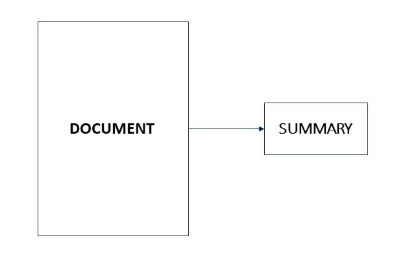


2. MAP REDUCE
   - multi-stage summarization
   - first we split document into chunks, than summarize each chunk, and finally combine those summaries into one
   - Pros: no limit for document size, each chunk can be processed in parallel (higher speed!)
   - Cons: multiple LLMs required; potential loss of information, because chunks are seen without context
     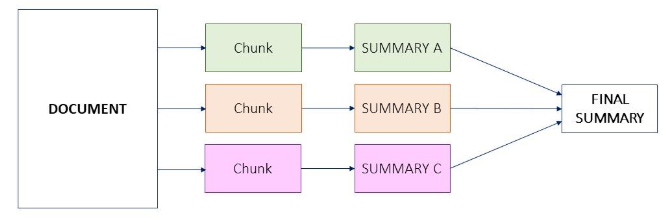

3. REFINE
   - multi-stage summarization; **ITTERATIVE APROACH**
   - first we split document into chunks, then the first chunk is summarized; afterwards, for each following chunk, the previous output is combined with new information(chunk) and then the LLM is used to improve(refine) previous summary
   - Pros: no limit for document size, MapReduce's problem of potential info loss is solved 
   - Cons: multiple LLMs required; LLM errors and hallucinations can propagade during each iteration affecting the quality of final output
     
   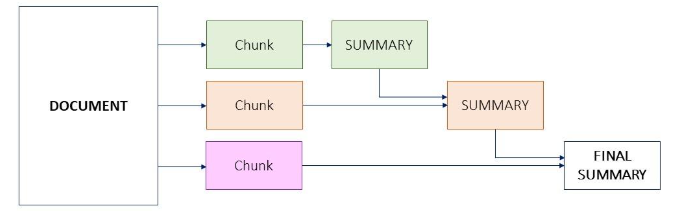

#### Document splitting strategies
- MapReduce and Refine strategies depend on document splitting!
- tokens are PARTS of the words (approx 1 token ~ 4 characters -> 1 token ~ 3/4 word -> 100tokens~75words
- Gemma has a maximum context length of 8192 tokes which is approx. 6100 words

- different strategies used for spliiting: based on character ('\n') or based on document structure(chapters, sections...); we chose strategy based on the task and document we need to analyze
- 3 scenarios:
  1. stuffing is feasible -> the best scenario, we simply pass the entire writeup to the model and get ok results
  2. stuffing is feasible but the ouptput is poor -> we suppose that writeup is not longer than 6100 words, but get poor output (poor summarization quality); our model could skip some sections -> we could use splitting writeups based on sections
  3. output is poor and writeups don't follow a clear structure -> the most difficult scenario, model struggles because of the lack of clear document structure ; moreover if the writeup is lengthy, it becomes even more challenging; solution-> a character splitting strategy 

In [7]:
example_clean_writeup = """
# Context section
This section only contains 2 links 
# Data context
link to the competition data page
# Overview of the Approach
this section should describe the models or algorithms used, describe the data preprocessing, feature engineering, and/or feature selection strategy, described the validation strategy.
# Details of the submission
this section should include what was special, creative, important, and/or impactful about the submission. And also, what was tried and didn’t work.
# Sources
this section should include links to helpful resources like research papers, past winning write-up solutions, forum posts, helpful notebooks, etc."""

example_messy_writeup = """
This section only contains 2 links, and here the link to the competition data page.
Partial section.
Another partial section.
Extensive model secondi which describes the models or algorithms used, describe the data preprocessing, feature engineering, and/or feature selection strategy, described the validation strategy.
Special section should include what was special, creative, important, and/or impactful about the submission. And also, what was tried and didn’t work. Last section should include links to helpful resources like research papers, past winning write-up solutions, forum posts, helpful notebooks, etc."""

In [8]:
# split the clean writeup based on sections
text_splitter = CharacterTextSplitter(separator="#", chunk_size=100, chunk_overlap=10)
texts_clean_writeup = text_splitter.split_text(example_clean_writeup)

print([i[:50] for i in texts_clean_writeup])

['# Context section\nThis section only contains 2 lin', 'Data context\nlink to the competition data page', 'Overview of the Approach\nthis section should descr', 'Details of the submission\nthis section should incl', 'Sources\nthis section should include links to helpf']


Paramteres:
- **separator**: the character to split the text on
- **chunk_size**: max size(max characters) of the one text chunk
- **chunk_overlap**: max number of characters from the previous chunk that will be repeated in the next chunk

->SO, CharacterTextSplitter first looks for the first 100 characters and then splits the next chunk from the closest separator

-> chunk_overlap only works if the chunks overlap by characters, which happens when there isn’t a strong separator!

In [9]:
# Split the messy writeup based on newlines
text_splitter = CharacterTextSplitter(separator='\n', chunk_size=100, chunk_overlap=50)
texts_messy_writeup= text_splitter.split_text(example_messy_writeup)

print([i[:50] for i in texts_messy_writeup])

['This section only contains 2 links, and here the l', 'Partial section.\nAnother partial section.', 'Extensive model secondi which describes the models', 'Special section should include what was special, c']


-> here we can see chunk_overlap because the second document includes a '\n' in its body

- actual writeups tend to be much more complicated
- let's demonstrate HTMLHeaderTextSplitter -> used for splitting html documents, using hierarchy

In [10]:
print(writeup)

<h2>TLDR</h2>
<p>We used an approach similar to audio spectrogram classification using the EfficientNet-B0 model, with numerous augmentations and transformer models such as BERT and DeBERTa as helper models. The final solution consists of one EfficientNet-B0 with an input size of 160x80, trained on a single fold from 8 randomly split folds, as well as DeBERTa and BERT trained on the full dataset. A single fold model using EfficientNet has a CV score of 0.898 and a leaderboard score of ~0.8.</p>
<p>We used only competition data.</p>
<h2>1. Data Preprocessing</h2>
<h3>1.1 CNN Preprocessing</h3>
<ul>
<li>We extracted 18 lip points, 20 pose points (including arms, shoulders, eyebrows, and nose), and all hand points, resulting in a total of 80 points.</li>
<li>During training, we applied various augmentations.</li>
<li>We implemented standard normalization.</li>
<li>Instead of dropping NaN values, we filled them with zeros after normalization.</li>
<li>We interpolated the time axis to a siz

In [11]:
headers_to_split_on = [
    ("h1", "Header 1"),
    ("h2", "Header 2")
]

html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on, return_each_element=False)
texts_html_writeup = html_splitter.split_text(writeup)

print(f"Length writeup: {len(writeup)}")
print(f"Number of splits: {len(texts_html_writeup)}")
print(f"Element returned: {type(texts_html_writeup[0])}")
print(f"Length of each split:{[len(i.page_content) for i in texts_html_writeup]}")

print(); print([(i.page_content[:50], i.metadata) for i in texts_html_writeup])

Length writeup: 9864
Number of splits: 12
Element returned: <class 'langchain_core.documents.base.Document'>
Length of each split:[4, 511, 21, 1658, 15, 1287, 11, 1301, 39, 1039, 36, 1807]

[('TLDR', {'Header 2': 'TLDR'}), ('We used an approach similar to audio spectrogram c', {'Header 2': 'TLDR'}), ('1. Data Preprocessing', {'Header 2': '1. Data Preprocessing'}), ('1.1 CNN Preprocessing  \nWe extracted 18 lip points', {'Header 2': '1. Data Preprocessing'}), ('2. Augmentation', {'Header 2': '2. Augmentation'}), ('2.1 Common Augmentations  \nThese augmentations are', {'Header 2': '2. Augmentation'}), ('3. Training', {'Header 2': '3. Training'}), ('3.1 CNN Training  \nTrain on one fold with a random', {'Header 2': '3. Training'}), ('4. Submissions, Conversion and Ensemble', {'Header 2': '4. Submissions, Conversion and Ensemble'}), ('We rewrote all our models in Keras and transferred', {'Header 2': '4. Submissions, Conversion and Ensemble'}), ('5. PS. Need   TFlite DepthwiseConv2D', {'Hea

In [12]:
# ???? idk why it does not work.. splits it wrongly...

- we can add metadata information back in the page content

In [13]:
for i, text in enumerate(texts_html_writeup):
    final_content = '\n'.join(text.metadata.values()) + '\n' + text.page_content
    text.page_content = final_content
    
    # Print some examples
    if i < 2:
        print(final_content); print()

TLDR
TLDR

TLDR
We used an approach similar to audio spectrogram classification using the EfficientNet-B0 model, with numerous augmentations and transformer models such as BERT and DeBERTa as helper models. The final solution consists of one EfficientNet-B0 with an input size of 160x80, trained on a single fold from 8 randomly split folds, as well as DeBERTa and BERT trained on the full dataset. A single fold model using EfficientNet has a CV score of 0.898 and a leaderboard score of ~0.8.  
We used only competition data.



- Now, we could use CharacterTextSplitter again, this time using split_documents() if we want to further split within each new chunk
- This could be helpful for very large documents, when even after splitting into sections, those sections are still too large

In [14]:
text_splitter = CharacterTextSplitter(chunk_size=2000, chunk_overlap=100)

splits=text_splitter.split_documents(texts_html_writeup)

print(f'Number of final splits:{len(splits)}')
print('Length of each final split: ', [len(i.page_content) for i in splits])
print()
print([i.page_content[:50] for i in splits])

Number of final splits:12
Length of each final split:  [9, 516, 43, 1680, 31, 1303, 23, 1313, 79, 1079, 73, 1844]

['TLDR\nTLDR', 'TLDR\nWe used an approach similar to audio spectrog', '1. Data Preprocessing\n1. Data Preprocessing', '1. Data Preprocessing\n1.1 CNN Preprocessing  \nWe e', '2. Augmentation\n2. Augmentation', '2. Augmentation\n2.1 Common Augmentations  \nThese a', '3. Training\n3. Training', '3. Training\n3.1 CNN Training  \nTrain on one fold w', '4. Submissions, Conversion and Ensemble\n4. Submiss', '4. Submissions, Conversion and Ensemble\nWe rewrote', '5. PS. Need   TFlite DepthwiseConv2D\n5. PS. Need  ', '5. PS. Need   TFlite DepthwiseConv2D\nBETTER  \nDept']


## Experiments

In [15]:
# defining a custom GemmaLLM class that wraps a Hugging Face pipeline for use with LangChain
class GemmaLLM(LLM):
    hf_pipe: Any = None
    pipe_kwargs: Any = None
        
    def __init__(self, hf_pipeline, pipe_kwargs):
        super(GemmaLLM, self).__init__()
        self.hf_pipe = hf_pipeline
        self.pipe_kwargs = pipe_kwargs

    @property
    def _llm_type(self):
        return "Gemma pipeline"

    def _call(self, prompt, **kwargs):
        """
        This is the part that gets invoked by LangChain. We make sure that we pass the parameters we
        previously discussed to the HF pipeline, returning only the output without the prompt.
        """
        outputs = self.hf_pipe(
            prompt,
            do_sample=self.pipe_kwargs['do_sample'],
            temperature=self.pipe_kwargs['temperature'],
            top_k=self.pipe_kwargs['top_k'],
            top_p=self.pipe_kwargs['top_p'],
            add_special_tokens=self.pipe_kwargs['add_special_tokens']
        )
        return outputs[0]["generated_text"][len(prompt):]  
    
    @property
    def _identifying_params(self):
        """Pipeline params"""
        return {"n": self.pipe_kwargs}


In [16]:
langchain_hf = GemmaLLM(hf_pipeline=pipe,
                        pipe_kwargs={
                            'do_sample':True,
                            'temperature':0.1,
                            'top_k':20,
                            'top_p':0.3,
                            'add_special_tokens':True
                })


In [17]:
print(prompt[:350])

<bos><start_of_turn>user
Summarize the following text in a technical way. Focus on facts, numbers and strategies used. Divide the summary in chapters, be impersonal and use bullet points:

<h2>TLDR</h2>
<p>We used an approach similar to audio spectrogram classification using the EfficientNet-B0 model, with numerous augmentations and transformer mod


In [18]:
out = langchain_hf.invoke(prompt)
display(Markdown(out.replace('#','')))

**Chapter 1: Introduction**

* Overview of the project: using an EfficientNet-B0 model for lip and pose classification.
* Data preparation:
    * 18 lip points, 20 pose points, and all hand points were extracted.
    * Various augmentations and transformer pre-processing were applied.
    * The input size was 160x80x3.

**Chapter 2: Data Preprocessing**

* CNN pre-processing:
    * Global affine, shift-scale-rotate, and flip pose were applied.
    * Mixup augmentation was used for CNNs.
* Transformer pre-processing:
    * Only 61 points were kept, including 40 lip points and 21 hand points.
    * Randomly selected distances and angles were included.

**Chapter 3: Training**

* CNN training:
    * One-fold cross-validation with a random split and 0.1 warm-up.
    * Weighted cross-entropy loss with class weights.
    * EfficientNet-B0 with 5 blocks and 256 hidden units.
* Transformer training:
    * One-fold cross-validation with a random split and 0.1 warm-up.
    * Ranger optimizer with 60% flat and 40% cosine annealing learning rate schedule.
    * 4-layer, 256 hidden-size, 512 intermediate-size transformer.

**Chapter 4: Hyperparameter Tuning**

* Optuna was used to tune most parameters.
* The parameters list for CNN and transformer training are provided.

**Chapter 5: Submissions and Ensemble**

* EfficientNet-B0 achieved a leaderboard score of approximately 0.8.
* Ensemble of EfficientNet-B0, BERT, and DeBERTa was created.
* A key feature was using the ensemble without softmax, which provided a boost of around 0.01.

**Chapter 6: Conclusion**

* The project achieved a high accuracy on the lip and pose classification task.
* The EfficientNet-B0 model with ensemble achieved the best performance.
* The conversion of DepthwiseConv2D operation was a challenge, but a faster version was developed.

#### To sum up, this was stuffing (whole propmt is passed), but now we're using GemmaLLM wrapper class for a HuggingFace pipeline
- instead of pipe(prompt, **kwargs), we are now using langchain_hf.invoke(prompt), which internally calls _call 
#### Now, let's see how does MapReduce and Refine work!

### MapReduce:

In [19]:
prompt_template = """<bos><start_of_turn>user
Summarize the following text in a technical way. Focus on facts, numbers and strategies used. Divide the summary in chapters, be impersonal and use bullet points:

{text}<end_of_turn>
<start_of_turn>model"""
prompt_init = PromptTemplate.from_template(prompt_template)


combine_template = """<bos><start_of_turn>user
You are given a text containing summaries of different part of a document.
Create one single summary combining all the information of the chapters. Divide the summary in chapters, be impersonal and use bullet points:

{text}<end_of_turn>
<start_of_turn>model"""
combine_prompt = PromptTemplate.from_template(combine_template)



# Create the chain of summarization, using map_reduce
chain = load_summarize_chain(langchain_hf, chain_type='map_reduce', map_prompt=prompt_init, combine_prompt=combine_prompt)
output = chain.invoke(splits)

display(Markdown(output['output_text'].replace('#','')))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3362 > 1024). Running this sequence through the model will result in indexing errors




**Chapter 1: Introduction**

* Definition of convolution
* Types of convolution
* Importance of convolution in image processing

**Chapter 2: Depthwise Convolution**

* Definition of depthwise convolution
* Advantages of depthwise convolution
* Applications of depthwise convolution

**Chapter 3: Experimental Results**

* Comparison of depthwise convolution and standard convolution
* Performance of depthwise convolution on different datasets
* Evaluation of FLOPs and runtime

**Chapter 4: Conclusion**

* Summary of key points
* Discussion of results and implications

In [20]:
# by adding verbose=true we can see steps in chain
chain = load_summarize_chain(langchain_hf, chain_type='map_reduce', verbose=True, map_prompt=prompt_init, combine_prompt=combine_prompt)

out_summary = chain.invoke(splits)
display(Markdown(out_summary['output_text'].replace('#', '')))



> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
<bos><start_of_turn>user
Summarize the following text in a technical way. Focus on facts, numbers and strategies used. Divide the summary in chapters, be impersonal and use bullet points:

TLDR
TLDR<end_of_turn>
<start_of_turn>model
Prompt after formatting:
<bos><start_of_turn>user
Summarize the following text in a technical way. Focus on facts, numbers and strategies used. Divide the summary in chapters, be impersonal and use bullet points:

TLDR
We used an approach similar to audio spectrogram classification using the EfficientNet-B0 model, with numerous augmentations and transformer models such as BERT and DeBERTa as helper models. The final solution consists of one EfficientNet-B0 with an input size of 160x80, trained on a single fold from 8 randomly split folds, as well as DeBERTa and BERT trained on the full dataset. A single fold model using EfficientNet has a CV score o



**Chapter 1: Introduction**

* Definition of convolution
* Types of convolution
* Importance of convolution in image processing

**Chapter 2: Depthwise Convolution**

* Definition of depthwise convolution
* Advantages of depthwise convolution
* Applications of depthwise convolution

**Chapter 3: Experimental Results**

* Comparison of depthwise convolution and standard convolution
* Performance of depthwise convolution on different datasets
* Evaluation of FLOPs and runtime

**Chapter 4: Conclusion**

* Summary of key points
* Discussion of results and implications

### Refine:

In [21]:
prompt_template = """<bos><start_of_turn>user
Summarize the following text in a technical way. Focus on facts, numbers and strategies used. Divide the summary in chapters, be impersonal and use bullet points:

{text}<end_of_turn>
<start_of_turn>model"""
propmt_init = PromptTemplate.from_template(prompt_template)

refine_template = """<bos><start_of_turn>user
Produce a final document divided in chapters and bullet points.
You are given a text containing an existing summary to a certain point:

{existing_answer}

You can now refine it (if necessary) with more context below.

{text}

Given the new context, refine the original summary.<end_of_turn>
<start_of_turn>model"""
refine_prompt = PromptTemplate.from_template(refine_template)


chain = load_summarize_chain(langchain_hf, chain_type='refine',
                             return_intermediate_steps=True,
                             input_key='input_documents',
                             output_key='output_text',
                             question_prompt=prompt_init,
                             refine_prompt=refine_prompt)

output = chain.invoke(splits,return_only_outputs=True)
display(Markdown((out_summary['output_text'].replace('#', ''))))




**Chapter 1: Introduction**

* Definition of convolution
* Types of convolution
* Importance of convolution in image processing

**Chapter 2: Depthwise Convolution**

* Definition of depthwise convolution
* Advantages of depthwise convolution
* Applications of depthwise convolution

**Chapter 3: Experimental Results**

* Comparison of depthwise convolution and standard convolution
* Performance of depthwise convolution on different datasets
* Evaluation of FLOPs and runtime

**Chapter 4: Conclusion**

* Summary of key points
* Discussion of results and implications